# ***Exploratory Data Analysis Financial Data***

- Create a stock trend similarity function comparison maker using a forecaster
- I want to take each function for the past month, and see which stocks are following a related trend

Import Packages

In [1]:
# Data Processing & Analysis
import pandas as pd
print(f"pandas: {pd.__version__}")

import numpy as np
print(f"numpy: {np.__version__}")

import yfinance as yf
print(f"yfinance: {yf.__version__}")

from datetime import datetime, timedelta

import sklearn
print(f"scikit-learn: {sklearn.__version__}")
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit

# Visualization
import matplotlib
print(f"matplotlib: {matplotlib.__version__}")
import matplotlib.pyplot as plt

import seaborn as sns
print(f"seaborn: {sns.__version__}")

# Machine Learning Models
from sklearn.ensemble import (
   RandomForestRegressor,
   GradientBoostingRegressor, 
   AdaBoostRegressor,
   VotingRegressor,
   StackingRegressor,
   BaggingRegressor
)
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression

import xgboost as xgb
print(f"xgboost: {xgb.__version__}")
from xgboost import XGBRegressor

# Time Series Specific
import statsmodels
print(f"statsmodels: {statsmodels.__version__}")
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from bs4 import BeautifulSoup
import requests
import re 

# Model Evaluation
from sklearn.metrics import (
   mean_squared_error,
   mean_absolute_error,
   r2_score,
   accuracy_score,
   precision_score,
   recall_score,
   f1_score
)

pandas: 2.2.3
numpy: 2.2.0
yfinance: 0.2.50
scikit-learn: 1.6.0
matplotlib: 3.10.0
seaborn: 0.13.2
xgboost: 2.1.3
statsmodels: 0.14.4


Extract S&P 500 list

In [2]:
r = requests.get('https://stockanalysis.com/list/sp-500-stocks/')

soup = BeautifulSoup(r.content, 'html.parser')

# Main =>
s = soup.find('main', class_='contain')

# Find all tds with class "sym svelte-eurwtr"
tds = s.find_all('td', class_='sym svelte-eurwtr')

SPY = []

for item in tds:
    # Find the text within the td
    ticker = item.find('a')
    ticker = ticker.text
    ticker = re.sub(r'[^a-zA-Z0-9]', '-', ticker)
    SPY.append(ticker)

print(SPY)

['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL', 'GOOG', 'META', 'TSLA', 'AVGO', 'BRK-B', 'WMT', 'LLY', 'JPM', 'V', 'MA', 'ORCL', 'XOM', 'UNH', 'COST', 'PG', 'NFLX', 'HD', 'JNJ', 'BAC', 'CRM', 'ABBV', 'KO', 'CVX', 'TMUS', 'MRK', 'ACN', 'WFC', 'CSCO', 'NOW', 'PEP', 'BX', 'MCD', 'AXP', 'IBM', 'DIS', 'LIN', 'TMO', 'ADBE', 'MS', 'AMD', 'ABT', 'PM', 'ISRG', 'GS', 'INTU', 'GE', 'CAT', 'PLTR', 'TXN', 'VZ', 'QCOM', 'BKNG', 'DHR', 'T', 'BLK', 'RTX', 'SPGI', 'HON', 'PFE', 'NEE', 'CMCSA', 'PGR', 'LOW', 'AMGN', 'ANET', 'SCHW', 'TJX', 'UNP', 'SYK', 'BA', 'ETN', 'AMAT', 'C', 'BSX', 'KKR', 'UBER', 'PANW', 'COP', 'ADP', 'FI', 'DE', 'BMY', 'NKE', 'LMT', 'GILD', 'CB', 'UPS', 'ADI', 'MMC', 'MDT', 'SBUX', 'VRTX', 'MU', 'PLD', 'LRCX', 'GEV', 'SO', 'MO', 'EQIX', 'CRWD', 'PYPL', 'SHW', 'CME', 'ICE', 'TT', 'KLAC', 'APH', 'AMT', 'MCO', 'CMG', 'ELV', 'INTC', 'CDNS', 'DUK', 'WM', 'PH', 'ABNB', 'MDLZ', 'DELL', 'WELL', 'MAR', 'MSI', 'ITW', 'AON', 'SNPS', 'PNC', 'CL', 'REGN', 'CI', 'HCA', 'CTAS', 'USB', 'ZTS', 'FTNT', 'MC

Gather Moving Average Data

In [12]:
def process_df(df):
    """
    Calculate the percent change for a day
    Calculate the moving average for 50 and 100 day periods
    Calculate the momentum
    """
    # Calculate Daily % Change
    df['Daily%Change'] = (((df['Close'] - df['Open']) / df['Open']) * 100).round(4)

    # Calculate 50-day Moving Average
    df['50DaySMA'] = df['Close'].rolling(window=50).mean()

    # Calculate 100-day Moving Average
    df['100DaySMA'] = df['Close'].rolling(window=100).mean()

    return df

In [21]:
ticker = "AAPL"
apple = yf.download(ticker, start="2023-01-01", end="2024-01-01")
apple.reset_index(inplace=True)
apple = process_df(apple).dropna()
apple.iloc[50:60].head(10)

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume,Daily%Change,50DaySMA,100DaySMA
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,
149,2023-08-08,178.447052,179.800003,180.270004,177.580002,179.690002,67823000,0.0612,187.363200,176.802500
150,2023-08-09,176.849197,178.190002,180.929993,177.009995,180.869995,60378500,-1.4817,187.418401,177.025900
151,2023-08-10,176.630844,177.970001,180.750000,177.600006,179.479996,54686900,-0.8413,187.431801,177.255600
152,2023-08-11,176.690460,177.789993,178.619995,176.550003,177.320007,51988100,0.2650,187.442600,177.459500
153,2023-08-14,178.350143,179.460007,179.690002,177.309998,177.970001,43675600,0.8372,187.430001,177.661300
154,2023-08-15,176.352570,177.449997,179.479996,177.050003,178.880005,43622600,-0.7994,187.360001,177.857500
155,2023-08-16,175.478012,176.570007,178.539993,176.500000,177.130005,46964900,-0.3162,187.299801,178.033900
156,2023-08-17,172.923904,174.000000,177.509995,173.479996,177.139999,66062900,-1.7726,187.195601,178.171400
157,2023-08-18,173.410889,174.490005,175.100006,171.960007,172.300003,61114200,1.2710,187.129001,178.333501


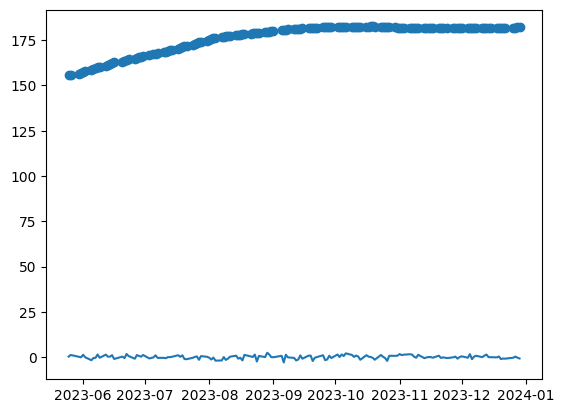

In [28]:
plt.plot(apple['Date'],apple['Daily%Change'])
plt.scatter(x=apple['Date'], y=apple['100DaySMA'])
plt.show()

Batch Datasets for each of the 500 companies

ML Modeling

Store in Datafile